We reused the code provided in the challenge resources and from there we optimized the filter and the LTA-STA algorithm. We obtained a folder with the filtered signals that are then analyzed with a machine learning algorithm to classify the moonquakes.



FIrst of all, we need to install obspy library, include libraries and packages

In [ ]:
try:
    import obspy
except:
    !pip install obspy

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import obspy
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os

After that, we mount our drive with NASA files

In [ ]:
from google.colab import drive
drive.mount('/content/drive');
import os.path

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We use the same header in the CSV file

In [ ]:
#Open directory
cat_directory = '/content/drive/MyDrive/space_apps_2024_seismic_detection/data/lunar/training/catalogs/'
cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
cat = pd.read_csv(cat_file)
cat

,filename,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),evid,mq_type
0,xa.s12.00.mhz.1970-01-19HR00_evid00002,1970-01-19T20:25:00.000000,73500.0,evid00002,impact_mq
1,xa.s12.00.mhz.1970-03-25HR00_evid00003,1970-03-25T03:32:00.000000,12720.0,evid00003,impact_mq
2,xa.s12.00.mhz.1970-03-26HR00_evid00004,1970-03-26T20:17:00.000000,73020.0,evid00004,impact_mq
3,xa.s12.00.mhz.1970-04-25HR00_evid00006,1970-04-25T01:14:00.000000,4440.0,evid00006,impact_mq
4,xa.s12.00.mhz.1970-04-26HR00_evid00007,1970-04-26T14:29:00.000000,52140.0,evid00007,deep_mq
...,...,...,...,...,...
71,xa.s12.00.mhz.1974-10-14HR00_evid00156,1974-10-14T17:43:00.000000,63780.0,evid00156,impact_mq
72,xa.s12.00.mhz.1975-04-12HR00_evid00191,1975-04-12T18:15:00.000000,65700.0,evid00191,impact_mq
73,xa.s12.00.mhz.1975-05-04HR00_evid00192,1975-05-04T10:05:00.000000,36300.0,evid00192,impact_mq
74,xa.s12.00.mhz.1975-06-24HR00_evid00196,1975-06-24T16:03:00.000000,57780.0,evid00196,impact_mq


Take the tip about using .mseed files, we used that kind of files. To call any sample we just change the value of the index variable. Enter the sample number you need (1-75)

In [ ]:
indice = 18;
row = cat.iloc[indice]
arrival_time = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'],'%Y-%m-%dT%H:%M:%S.%f')
# If we want the value of relative time, we don't need to use datetime
arrival_time_rel = row['time_rel(sec)']
# Let's also get the name of the file
test_filename = row.filename
test_filename

'xa.s12.00.mhz.1971-02-09HR00_evid00026'

In [ ]:
data_directory = '/content/drive/MyDrive/space_apps_2024_seismic_detection/data/lunar/training/data/S12_GradeA/'
mseed_file = f'{data_directory}{test_filename}.mseed'
st = read(mseed_file)
# The stream file also contains some useful header information
st[0].stats

         network: XA
         station: S12
        location: 00
         channel: MHZ
       starttime: 1971-02-09T00:00:00.179000Z
         endtime: 1971-02-10T00:00:01.688434Z
   sampling_rate: 6.625
           delta: 0.1509433962264151
            npts: 572411
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 1136, 'encoding': 'FLOAT64', 'byteorder': '>', 'record_length': 4096, 'filesize': 4653056})

Text(0.5, 1.0, 'xa.s12.00.mhz.1971-02-09HR00_evid00026')

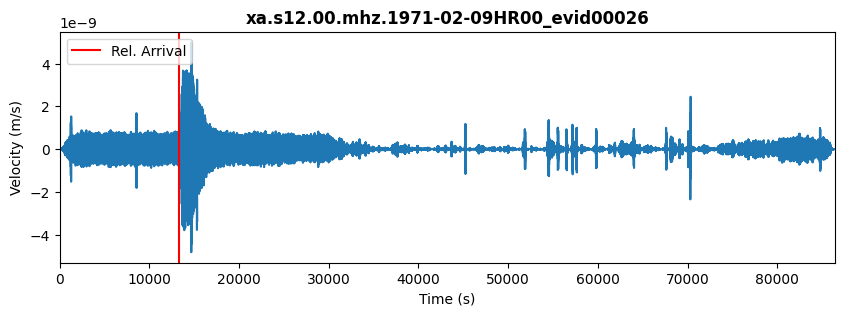

In [ ]:
# This is how you get the data and the time, which is in seconds
tr = st.traces[0].copy()
tr_times = tr.times()
tr_data = tr.data
# Start time of trace (another way to get the relative arrival time using datetime)
starttime = tr.stats.starttime.datetime
arrival = (arrival_time - starttime).total_seconds()
# Initialize figure
fig,ax = plt.subplots(1,1,figsize=(10,3))

# Plot trace
ax.plot(tr_times,tr_data)

# Mark detection
ax.axvline(x = arrival, color='red',label='Rel. Arrival')
ax.legend(loc='upper left')

# Make the plot pretty
ax.set_xlim([min(tr_times),max(tr_times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'{test_filename}', fontweight='bold')

Text(0.5, 1.0, 'xa.s12.00.mhz.1971-02-09HR00_evid00026')

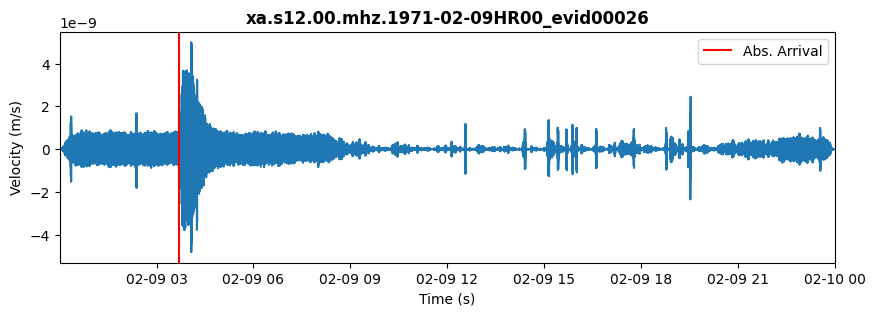

In [ ]:
# Create a vector for the absolute time
tr_times_dt = []
for tr_val in tr_times:
    tr_times_dt.append(starttime + timedelta(seconds=tr_val))

# Plot the absolute result
fig,ax = plt.subplots(1,1,figsize=(10,3))

# Plot trace
ax.plot(tr_times_dt,tr_data)

# Mark detection
arrival_line = ax.axvline(x=arrival_time, c='red', label='Abs. Arrival')
ax.legend(handles=[arrival_line])

# Make the plot pretty
ax.set_xlim([min(tr_times_dt),max(tr_times_dt)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'{test_filename}', fontweight='bold')

Adaptative filter



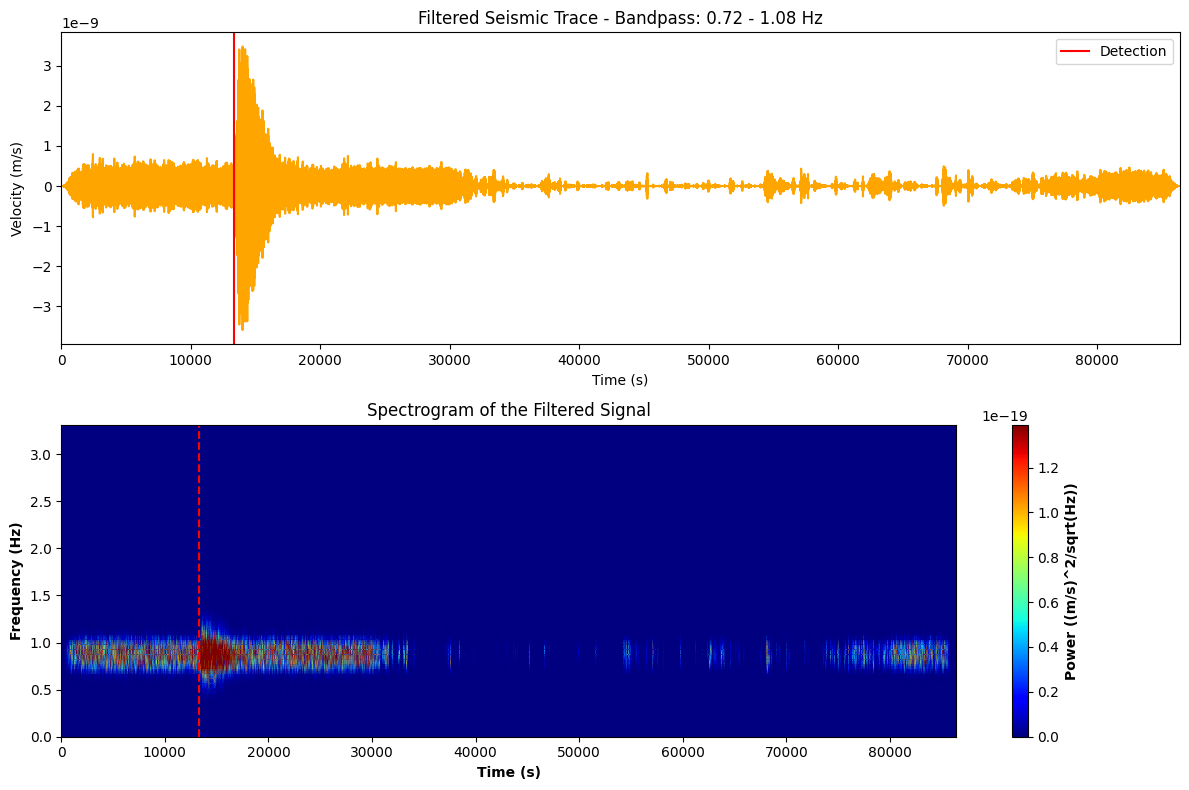

In [ ]:
import matplotlib.pyplot as plt
from scipy import signal
from matplotlib import cm
import numpy as np

# Function to downsample the signal if necessary
def downsample_signal(trace, target_rate):
    """
    Decreases the sampling rate of the signal to optimize calculations.
    :param trace: Original seismic trace.
    :param target_rate: Target sampling rate.
    :return: Seismic trace with reduced sampling rate.
    """
    original_rate = trace.stats.sampling_rate
    if original_rate > target_rate:
        decimation_factor = int(original_rate // target_rate)
        trace_decimated = trace.copy()
        trace_decimated.data = signal.decimate(trace.data, decimation_factor, zero_phase=True)
        trace_decimated.stats.sampling_rate = target_rate
        return trace_decimated
    return trace

# Function to compute the dominant frequency of the signal
def get_dominant_frequency(trace, sampling_rate):
    """
    Calculates the dominant frequency of the signal using FFT.
    :param trace: Seismic trace data.
    :param sampling_rate: Signal's sampling rate.
    :return: Dominant frequency of the signal.
    """
    freqs, power_spectrum = signal.periodogram(trace, fs=sampling_rate)
    dominant_freq = freqs[np.argmax(power_spectrum)]  # Frequency with the highest power
    return dominant_freq

# High-pass filter function to remove unwanted low-frequency components
def highpass_filter(trace, cutoff_freq=0.1):
    """
    Applies a high-pass filter to remove unwanted low-frequency components.
    :param trace: Seismic trace to filter.
    :param cutoff_freq: Cutoff frequency of the filter (Hz).
    :return: Filtered seismic trace.
    """
    trace_highpass = trace.copy()
    trace_highpass.filter('highpass', freq=cutoff_freq, corners=4, zerophase=True)
    return trace_highpass

# Function to apply an adaptive bandpass filter based on the dominant frequency
def apply_adaptive_bandpass_filter(trace, sampling_rate, factor=0.2, noise_filtering=True):
    """
    Applies an adaptive bandpass filter based on the signal's dominant frequency.
    :param trace: Seismic trace to filter.
    :param sampling_rate: Signal's sampling rate.
    :param factor: Factor to define the frequency range.
    :param noise_filtering: If True, applies a high-pass noise pre-filter.
    :return: Filtered trace, minimum and maximum frequencies used.
    """
    # Apply noise pre-filtering using a high-pass filter if noise_filtering is True
    if noise_filtering:
        trace = highpass_filter(trace, cutoff_freq=0.1)

    # Get the dominant frequency of the signal
    dominant_freq = get_dominant_frequency(trace, sampling_rate)

    # Define the adaptive frequency range based on the dominant frequency
    minfreq = max(0.1, dominant_freq - factor * dominant_freq)  # Adaptive minimum frequency
    maxfreq = dominant_freq + factor * dominant_freq  # Adaptive maximum frequency

    # Apply the adaptive bandpass filter using an IIR filter for better efficiency
    trace_filtered = trace.copy()
    trace_filtered.filter('bandpass', freqmin=minfreq, freqmax=maxfreq, corners=4, zerophase=True)
    return trace_filtered, minfreq, maxfreq

# Function to compute the spectrogram of the signal
def compute_spectrogram(trace, sampling_rate):
    """
    Calculates the spectrogram of the signal using `scipy.signal.spectrogram`.
    :param trace: Signal data.
    :param sampling_rate: Signal's sampling rate.
    :return: Frequencies, times, and power spectrum of the signal.
    """
    # Reduce spectrogram resolution to save memory
    f, t, sxx = signal.spectrogram(trace, sampling_rate, nperseg=128, noverlap=64)
    return f, t, sxx

# Function to visualize the filtered signal and its spectrogram
def plot_filtered_signal_and_spectrogram(tr_times, tr_data, arrival, f, t, sxx, minfreq, maxfreq):
    """
    Visualizes the filtered seismic signal along with its spectrogram.
    :param tr_times: Signal times.
    :param tr_data: Filtered signal data.
    :param arrival: Detection arrival time.
    :param f: Spectrogram frequencies.
    :param t: Spectrogram times.
    :param sxx: Spectrogram power.
    :param minfreq: Minimum frequency used in the filter.
    :param maxfreq: Maximum frequency used in the filter.
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

    # Plot the filtered signal
    ax1.plot(tr_times, tr_data, color='orange')
    ax1.axvline(x=arrival, color='red', label='Detection')
    ax1.legend(loc='upper right')
    ax1.set_xlim([min(tr_times), max(tr_times)])
    ax1.set_ylabel('Velocity (m/s)')
    ax1.set_xlabel('Time (s)')
    ax1.set_title(f'Filtered Seismic Trace - Bandpass: {minfreq:.2f} - {maxfreq:.2f} Hz')

    # Plot the spectrogram
    vals = ax2.pcolormesh(t, f, sxx, shading='gouraud', cmap=cm.jet, vmax=np.percentile(sxx, 99))
    ax2.set_xlim([min(tr_times), max(tr_times)])
    ax2.set_xlabel('Time (s)', fontweight='bold')
    ax2.set_ylabel('Frequency (Hz)', fontweight='bold')
    ax2.axvline(x=arrival, color='red', linestyle='--')
    cbar = fig.colorbar(vals, ax=ax2, orientation='vertical')
    cbar.set_label('Power ((m/s)^2/sqrt(Hz))', fontweight='bold')
    ax2.set_title('Spectrogram of the Filtered Signal')
    plt.tight_layout()
    plt.show()

# Downsample the signal to optimize calculations
target_sampling_rate = 50  # Target sampling rate (adjustable)
st_resampled = downsample_signal(st[0], target_sampling_rate)

# Apply the adaptive filter to the resampled trace with noise pre-filtering
st_filt, minfreq, maxfreq = apply_adaptive_bandpass_filter(st_resampled, st_resampled.stats.sampling_rate, factor=0.2)

# Obtain times and data from the filtered trace
tr_times_filt = st_filt.times()
tr_data_filt = st_filt.data

# Calculate the spectrogram of the filtered signal
f, t, sxx = compute_spectrogram(tr_data_filt, st_filt.stats.sampling_rate)

# Visualize the filtered signal and its spectrogram
plot_filtered_signal_and_spectrogram(tr_times_filt, tr_data_filt, arrival, f, t, sxx, minfreq, maxfreq)


STA / LTA upgraded

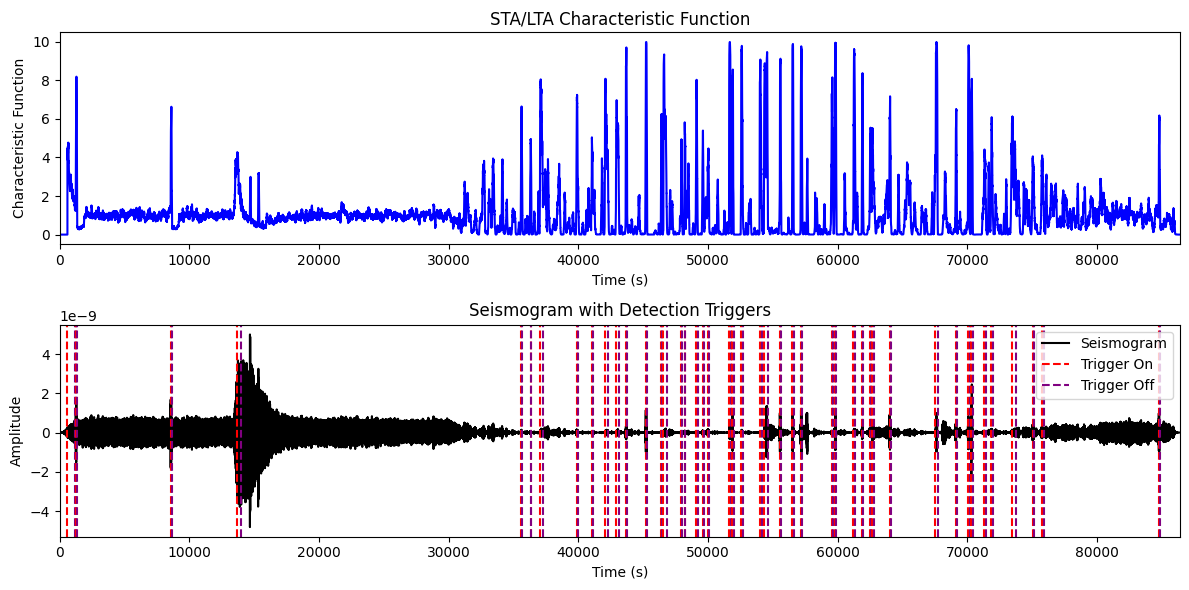

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from obspy.signal.trigger import classic_sta_lta, trigger_onset

# Define an optimized function for STA-LTA calculation and visualization
def optimized_sta_lta_detection(tr_data, tr_times, df, sta_len=60, lta_len=600, thr_on=4, thr_off=1.5):
    """
    Optimized STA/LTA detection function to identify seismic events.

    :param tr_data: Seismic trace data (amplitude values).
    :param tr_times: Time values corresponding to the trace.
    :param df: Sampling rate of the signal (Hz).
    :param sta_len: Short Time Average (STA) window length in seconds.
    :param lta_len: Long Time Average (LTA) window length in seconds.
    :param thr_on: Trigger activation threshold (ratio of STA/LTA).
    :param thr_off: Trigger deactivation threshold (ratio of STA/LTA).
    :return: Array containing the indices of the start and end of detected events.
    """

    # Calculate the STA/LTA characteristic function using sliding windows
    cft = classic_sta_lta(tr_data, int(sta_len * df), int(lta_len * df))

    # Calculate the onset and offset indices of the triggers (detections)
    on_off = np.array(trigger_onset(cft, thr_on, thr_off))

    # Visualize the seismogram and the detection triggers
    fig, ax = plt.subplots(2, 1, figsize=(12, 6))

    # First plot: STA/LTA Characteristic Function
    ax[0].plot(tr_times, cft, color='blue')
    ax[0].set_xlim([min(tr_times), max(tr_times)])
    ax[0].set_ylabel('Characteristic Function')
    ax[0].set_xlabel('Time (s)')
    ax[0].set_title('STA/LTA Characteristic Function')

    # Second plot: Seismogram with detection markers
    ax[1].plot(tr_times, tr_data, color='black', label='Seismogram')

    # Add vertical lines for detected events, ensuring labels are only added once
    trigger_on_label = 'Trigger On'
    trigger_off_label = 'Trigger Off'

    for i, (start, end) in enumerate(on_off):
        if i == 0:  # Only add the label on the first iteration
            ax[1].axvline(x=tr_times[start], color='red', linestyle='--', label=trigger_on_label)
            ax[1].axvline(x=tr_times[end], color='purple', linestyle='--', label=trigger_off_label)
        else:
            ax[1].axvline(x=tr_times[start], color='red', linestyle='--')
            ax[1].axvline(x=tr_times[end], color='purple', linestyle='--')

    ax[1].set_xlim([min(tr_times), max(tr_times)])
    ax[1].set_ylabel('Amplitude')
    ax[1].set_xlabel('Time (s)')
    ax[1].legend(loc='upper right')
    ax[1].set_title('Seismogram with Detection Triggers')

    plt.tight_layout()  # Adjust subplots to prevent overlap
    plt.show()

    return on_off  # Return the indices of detected events

# Example parameters for the seismic trace
df = tr.stats.sampling_rate  # Sampling rate of the trace
sta_len = 60  # Length of the STA window in seconds
lta_len = 600  # Length of the LTA window in seconds
thr_on = 4  # Threshold for detection activation
thr_off = 1.5  # Threshold for detection deactivation

# Apply the optimized STA/LTA algorithm to detect events
on_off_detections = optimized_sta_lta_detection(tr_data, tr_times, df, sta_len, lta_len, thr_on, thr_off)


Exported filtered data

In [ ]:
# File name and start time of trace
fname = row.values[0]
starttime = tr.stats.starttime.datetime

on_off = on_off_detections
# Iterate through detection times and compile them
detection_times = []
fnames = []
for i in np.arange(0,len(on_off)):
    triggers = on_off[i]
    on_time = starttime + timedelta(seconds = tr_times[triggers[0]])
    on_time_str = datetime.strftime(on_time,'%Y-%m-%dT%H:%M:%S.%f')
    detection_times.append(on_time_str)
    fnames.append(fname)

# Compile dataframe of detections
detect_df = pd.DataFrame(data = {'filename':fnames, 'time_abs(%Y-%m-%dT%H:%M:%S.%f)':detection_times, 'time_rel(sec)':tr_times[triggers[0]]})
detect_df.head()
detect_df

,filename,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec)
0,xa.s12.00.mhz.1971-02-09HR00_evid00026,1971-02-09T00:10:00.028057,84772.679245
1,xa.s12.00.mhz.1971-02-09HR00_evid00026,1971-02-09T00:20:50.745038,84772.679245
2,xa.s12.00.mhz.1971-02-09HR00_evid00026,1971-02-09T02:22:51.650698,84772.679245
3,xa.s12.00.mhz.1971-02-09HR00_evid00026,1971-02-09T03:48:15.575226,84772.679245
4,xa.s12.00.mhz.1971-02-09HR00_evid00026,1971-02-09T09:53:02.518623,84772.679245
5,xa.s12.00.mhz.1971-02-09HR00_evid00026,1971-02-09T10:05:12.329943,84772.679245
6,xa.s12.00.mhz.1971-02-09HR00_evid00026,1971-02-09T10:17:27.122396,84772.679245
7,xa.s12.00.mhz.1971-02-09HR00_evid00026,1971-02-09T11:04:23.122396,84772.679245
8,xa.s12.00.mhz.1971-02-09HR00_evid00026,1971-02-09T11:24:00.480887,84772.679245
9,xa.s12.00.mhz.1971-02-09HR00_evid00026,1971-02-09T11:40:51.046925,84772.679245


In [ ]:
ind =str(indice)
ubi='/content/drive/MyDrive/space_apps_2024_seismic_detection/data/lunar/training/recortes/recorte'+ind+'.csv'
detect_df.to_csv(ubi, index=False)

In [82]:
# implement a linear regression machine learning model to classify earthquakes into 3 categories: deepquakes, shallowquakes and impacts
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Load the dataframe
df = pd.read_csv(ubi)
event_types = ['deepquake', 'shallowquake', 'impact'] * (len(df) // 3) + ['deepquake', 'shallowquake'][:len(df) % 3]  # Adjust as needed
df['event_type'] = event_types

df.rename(columns={"Start_Index": "time_rel(sec)"}, inplace=True)
X = df[['time_rel(sec)']] # Features
y = df['event_type'] # Labels

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# machine learning model (Logistic Regression)
model = LogisticRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

Accuracy: 0.2222222222222222
              precision    recall  f1-score   support

   deepquake       0.20      0.50      0.29         2
      impact       0.00      0.00      0.00         4
shallowquake       0.25      0.33      0.29         3

    accuracy                           0.22         9
   macro avg       0.15      0.28      0.19         9
weighted avg       0.13      0.22      0.16         9



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Predictions